## Predict Customer Churn Use Case Implementation
The objective is to follow the CRISP-DM methodology to build a model to predict customer churn
![CRISP-DM](https://raw.githubusercontent.com/yfphoon/dsx_demo/master/crisp_dm.png)

### Step 1: Download the customer churn data

In [1]:
#Run once to install the wget package
!pip install wget

In [2]:
# download data from GitHub repository
import wget
url_churn='https://raw.githubusercontent.com/yfphoon/dsx_demo/master/data/customer_churn/churn.csv'
url_customer='https://raw.githubusercontent.com/yfphoon/dsx_demo/master/data/customer_churn/customer.csv'

#remove existing files before downloading
!rm -f churn.csv
!rm -f customer.csv

churnFilename=wget.download(url_churn)
customerFilename=wget.download(url_customer)

#list existing files
!ls -l churn.csv
!ls -l customer.csv

-rw------- 1 s3b2-c7634938ff52ab-a5f39cf201a0 users 20079 Nov 13 09:09 churn.csv
-rw------- 1 s3b2-c7634938ff52ab-a5f39cf201a0 users 279541 Nov 13 09:09 customer.csv


### Step 2: Read data into Spark DataFrames

Note: You want to reference the Spark DataFrame API to learn more about the supported operations, https://spark.apache.org/docs/2.0.0-preview/api/python/pyspark.sql.html#pyspark.sql.DataFrame

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

churn= spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option("inferSchema", "true")\
  .load("churn.csv")

customer = spark.read\
    .format("org.apache.spark.sql.execution.datasources.csv.CSVFileFormat")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("customer.csv")

### Step 3: Merge Files


In [4]:
data=customer.join(churn,customer['ID']==churn['ID']).select(customer['*'],churn['CHURN'])
data.toPandas().head()

,ID,Gender,Status,Children,Est Income,Car Owner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,CHURN
0,1,F,S,1,38000.00,N,24.393333,23.56,0,206.08,0,CC,Budget,Intnl_discount,229.64,3,T
1,6,M,M,2,29616.00,N,49.426667,29.78,0,45.50,0,CH,FreeLocal,Standard,75.29,2,F
2,8,M,M,0,19732.80,N,50.673333,24.81,0,22.44,0,CC,FreeLocal,Standard,47.25,3,F
3,11,M,S,2,96.33,N,56.473333,26.13,0,32.88,1,CC,Budget,Standard,59.01,1,F
4,14,F,M,2,52004.80,N,25.140000,5.03,0,23.11,0,CH,Budget,Intnl_discount,28.14,1,F


### Step 4: Rename some columns
This step is not a requirement, it just makes some columns names simpler to type with no spaces

In [5]:
# withColumnRenamed renames an existing column in a SparkDataFrame and returns a new SparkDataFrame

data = data.withColumnRenamed("Est Income", "EstIncome").withColumnRenamed("Car Owner","CarOwner")
data.toPandas().head()

,ID,Gender,Status,Children,EstIncome,CarOwner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,CHURN
0,1,F,S,1,38000.00,N,24.393333,23.56,0,206.08,0,CC,Budget,Intnl_discount,229.64,3,T
1,6,M,M,2,29616.00,N,49.426667,29.78,0,45.50,0,CH,FreeLocal,Standard,75.29,2,F
2,8,M,M,0,19732.80,N,50.673333,24.81,0,22.44,0,CC,FreeLocal,Standard,47.25,3,F
3,11,M,S,2,96.33,N,56.473333,26.13,0,32.88,1,CC,Budget,Standard,59.01,1,F
4,14,F,M,2,52004.80,N,25.140000,5.03,0,23.11,0,CH,Budget,Intnl_discount,28.14,1,F


### Step 5: Data understanding

### Dataset Overview

In [6]:
df_pandas = data.toPandas()
print "There are " + str(len(df_pandas)) + " observations in the customer history dataset."
print "There are " + str(len(df_pandas.columns)) + " variables in the dataset."

print "\n******************Descriptive statistics*****************************\n"
print df_pandas.drop(['ID'], axis = 1).describe()


There are 2066 observations in the customer history dataset.
There are 17 variables in the dataset.

******************Descriptive statistics*****************************

          Children      EstIncome          Age  LongDistance  International  \
count  2066.000000    2066.000000  2066.000000   2066.000000    2066.000000   
mean      1.146176   51514.070465    42.783982     16.122076       1.191104   
std       0.843105   30805.652721    14.894693      9.874795       2.602010   
min       0.000000      96.330000    12.326667      0.000000       0.000000   
25%       0.000000   21021.600000    30.356667      8.090000       0.000000   
50%       1.000000   55860.000000    45.526667     16.140000       0.000000   
75%       2.000000   78000.000000    54.013333     22.990000       0.000000   
max       2.000000  120000.000000    77.000000     59.000000       9.700000   

             Local      Dropped        Usage     RatePlan  
count  2066.000000  2066.000000  2066.000000  2066.00000

### Exploratory Data Analysis

The **Brunel** Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and more aggressive business users. The system interprets the language and produces visualizations using the user's choice of existing lower-level visualization technologies typically used by application engineers such as RAVE or D3. 

More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

Try Brunel visualization here:  http://brunel.mybluemix.net/gallery_app/renderer

In [7]:
import brunel
df_pandas = data.toPandas()
%brunel data('df_pandas') stack bar x(Paymethod) y(#count) color(CHURN) bin(Paymethod) percent(#count) label(#count) tooltip(#all) | x(LongDistance) y(Usage) point color(Paymethod) tooltip(LongDistance, Usage) :: width=1100, height=400 

<IPython.core.display.Javascript object>

In [8]:
# Heat map
%brunel data('df_pandas') x(LocalBilltype) y(Dropped) color(#count:red) style('symbol:rect; size:100%; stroke:none') tooltip(Dropped,#count)

<IPython.core.display.Javascript object>

**PixieDust** is a Python Helper library for Spark IPython Notebooks. One of it's main features are visualizations. You'll notice that unlike other APIs which produce just output, PixieDust creates an interactive UI in which you can explore data.<br/>
More information about PixieDust: https://github.com/ibm-cds-labs/pixiedust?cm_mc_uid=78151411419314871783930&cm_mc_sid_50200000=1487962969

**If you haven't already installed it, uncomment and run the following cell to install the pixiedust Python library in your notebook environment. You only need to run it once**


In [12]:
#!pip install --user --upgrade pixiedust


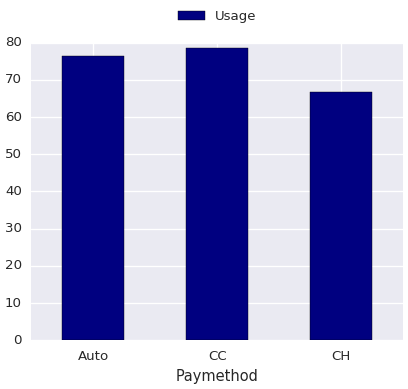

In [13]:
from pixiedust.display import *
display(data)

### Interactive query with Spark SQL

In [14]:
# Spark SQL also allow you to use standard SQL
data.createOrReplaceTempView("data")
sql = """
SELECT c.*
FROM data c
WHERE c.EstIncome>90000

"""
spark.sql(sql).toPandas().head()

,ID,Gender,Status,Children,EstIncome,CarOwner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,CHURN
0,61,M,S,2,100020.0,N,50.000000,21.37,0.00,293.24,0,CH,Budget,Standard,314.62,4,T
1,79,F,S,0,98716.3,N,55.660000,20.97,8.23,13.92,0,CC,FreeLocal,Standard,43.13,4,T
2,87,M,M,1,97180.4,N,50.600000,8.21,9.63,45.66,0,CC,FreeLocal,Standard,63.51,4,T
3,109,M,S,1,92647.5,N,56.046667,16.04,5.74,10.34,0,CC,Budget,Standard,32.13,4,T
4,148,M,M,2,91272.2,Y,25.033333,26.99,0.00,13.01,0,CC,FreeLocal,Standard,40.00,3,F


### Step 6: Build the Spark pipeline and the Random Forest model
"Pipeline" is an API in SparkML that's used for building models. A pipeline defines a sequence of transformers and estimators to perform tha analysis in stages.<br/>
Additional information on SparkML: https://spark.apache.org/docs/2.0.2/ml-guide.html

In [15]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# StringIndexer encodes a string column of labels to a column of label indices. 
SI1 = StringIndexer(inputCol='Gender', outputCol='GenderEncoded')
SI2 = StringIndexer(inputCol='Status',outputCol='StatusEncoded')
SI3 = StringIndexer(inputCol='CarOwner',outputCol='CarOwnerEncoded')
SI4 = StringIndexer(inputCol='Paymethod',outputCol='PaymethodEncoded')
SI5 = StringIndexer(inputCol='LocalBilltype',outputCol='LocalBilltypeEncoded')
SI6 = StringIndexer(inputCol='LongDistanceBilltype',outputCol='LongDistanceBilltypeEncoded')

# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["GenderEncoded", "StatusEncoded", "CarOwnerEncoded", "PaymethodEncoded", "LocalBilltypeEncoded", \
                                       "LongDistanceBilltypeEncoded", "Children", "EstIncome", "Age", "LongDistance", "International", "Local",\
                                      "Dropped","Usage","RatePlan"], outputCol="features")

In [16]:
# encode the label column
labelIndexer = StringIndexer(inputCol='CHURN', outputCol='label').fit(data)

In [17]:
# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

In [18]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

In [19]:
# build the pipeline
pipeline = Pipeline(stages=[SI1,SI2,SI3,SI4,SI5,SI6, labelIndexer, assembler, rf, labelConverter])

In [20]:
# Split data into train and test datasets
(trainingData, testingData) = data.randomSplit([0.7, 0.3],seed=9)
trainingData.cache()
testingData.cache()

DataFrame[ID: int, Gender: string, Status: string, Children: double, EstIncome: double, CarOwner: string, Age: double, LongDistance: double, International: double, Local: double, Dropped: double, Paymethod: string, LocalBilltype: string, LongDistanceBilltype: string, Usage: double, RatePlan: double, CHURN: string]

In [21]:
# Build model. The fitted model from a Pipeline is a PipelineModel, which consists of fitted models and transformers, corresponding to the pipeline stages.
model = pipeline.fit(trainingData)

### Step 7: Score the test data set

In [22]:
result=model.transform(testingData)
result_display=result.select(result["ID"],result["CHURN"],result["Label"],result["predictedLabel"],result["prediction"],result["probability"])
result_display.toPandas().head(6)

,ID,CHURN,Label,predictedLabel,prediction,probability
0,1,T,1,T,1,"[0.0390066830438, 0.960993316956]"
1,18,F,0,F,0,"[0.604568153513, 0.395431846487]"
2,22,F,0,F,0,"[0.743416529489, 0.256583470511]"
3,23,F,0,F,0,"[0.92480094066, 0.0751990593396]"
4,29,T,1,T,1,"[0.134435036135, 0.865564963865]"
5,40,T,1,T,1,"[0.222010772111, 0.777989227889]"


### Step 8: Model Evaluation
Find accuracy of the models and the Area Under the ROC Curve 

In [23]:
print 'Model Accuracy = {:.2f}.'.format(result.filter(result.label == result.prediction).count() / float(result.count()))

Model Accuracy = 0.92.


In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print 'Area under ROC curve = {:.2f}.'.format(evaluator.evaluate(result))

Area under ROC curve = 0.91.


###  Step 9:  Tune the model to find the best model

#### Build a Parameter Grid specifying the parameters to be evaluated to determine the best combination

In [25]:
# set different levels for the maxDepth
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder().addGrid(rf.maxDepth,[4,6,8]).build())

#### Create a cross validator to tune the pipeline with the generated parameter grid
Cross-validation attempts to fit the underlying estimator with user-specified combinations of parameters, cross-evaluate the fitted models, and output the best one.

In [26]:
# perform 3 fold cross validation
cv = CrossValidator().setEstimator(pipeline).setEvaluator(evaluator).setEstimatorParamMaps(paramGrid).setNumFolds(3)

In [27]:
# train the model
cvModel = cv.fit(trainingData)

# pick the best model
best_rfModel = cvModel.bestModel

In [28]:
# score the test data set with the best model
cvresult=best_rfModel.transform(testingData)
cvresults_show=cvresult.select(cvresult["ID"],cvresult["CHURN"],cvresult["Label"],cvresult["predictedLabel"],cvresult["prediction"],cvresult["probability"])
cvresults_show.toPandas().head()

,ID,CHURN,Label,predictedLabel,prediction,probability
0,1,T,1,T,1,"[0.00054347826087, 0.999456521739]"
1,18,F,0,F,0,"[0.834106919825, 0.165893080175]"
2,22,F,0,F,0,"[0.968899931172, 0.0311000688284]"
3,23,F,0,F,0,"[0.919090909091, 0.0809090909091]"
4,29,T,1,T,1,"[0.000862068965517, 0.999137931034]"


In [29]:

print 'Model Accuracy of the best fitted model = {:.2f}.'.format(cvresult.filter(cvresult.label == cvresult.prediction).count()/ float(cvresult.count()))
print 'Model Accuracy of the default model = {:.2f}.'.format(result.filter(result.label == result.prediction).count() / float(result.count()))
print '   '
print('Area under the ROC curve of best fitted model = {:.2f}.'.format(evaluator.evaluate(cvresult)))
print 'Area under the ROC curve of the default model = {:.2f}.'.format(evaluator.evaluate(result))

Model Accuracy of the best fitted model = 0.97.
Model Accuracy of the default model = 0.92.
   
Area under the ROC curve of best fitted model = 0.96.
Area under the ROC curve of the default model = 0.91.


### Step 10: Save Model
Save the best model. 

A separate notebook has been created for "batch scoring deployment". This deployment notebook retrieves the saved model and applies it to a new dataset. The notebook can be scheduled to run via the Notebook scheduler or through the deployment interface in IBM WML.

In [30]:
# Overwrite any existing saved model in the specified path
best_rfModel.write().overwrite().save("PredictChurn.churnModel")